<a href="https://colab.research.google.com/github/AnxietySquid/fake_news_detection/blob/main/PRFakeNews_eremin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# data analysis and preparation

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TheFounder/PR/Fake news/Data/fake_news.csv')

In [ ]:
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB
None


,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


Колонка unnamed явно не будет нужна в обучении, а заголовок можно объединить с текстом

In [ ]:
df['text'] = df['title'] + df['text']

In [ ]:
df = df.drop(columns=['Unnamed: 0', 'title'])

In [ ]:
display(df.head())

,text,label
0,"You Can Smell Hillary’s FearDaniel Greenfield,...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,FAKE
2,Kerry to go to Paris in gesture of sympathyU.S...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,FAKE
4,The Battle of New York: Why This Primary Matte...,REAL


Лейблы заменим на:  
FAKE = 0
REAL = 1

In [ ]:
# Убедимся, что в столбце только FAKE и REAL
display(df.label.unique())

array(['FAKE', 'REAL'], dtype=object)

In [ ]:
df.loc[df['label'] == 'FAKE', 'label'] = 0
df.loc[df['label'] == 'REAL', 'label'] = 1
display(df.head())

,text,label
0,"You Can Smell Hillary’s FearDaniel Greenfield,...",0
1,Watch The Exact Moment Paul Ryan Committed Pol...,0
2,Kerry to go to Paris in gesture of sympathyU.S...,1
3,Bernie supporters on Twitter erupt in anger ag...,0
4,The Battle of New York: Why This Primary Matte...,1


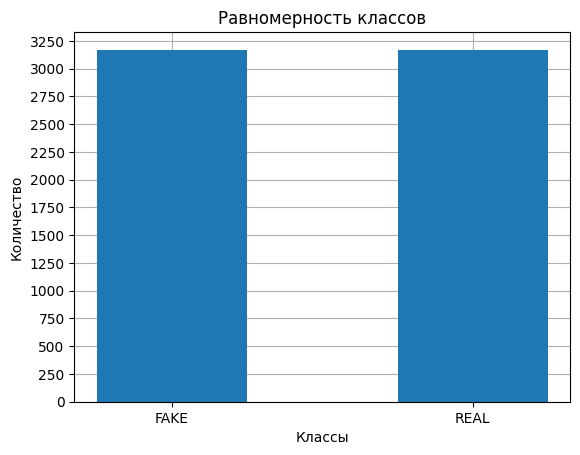

Количество FAKE: 3164
Количество REAL: 3171


In [ ]:
# Убедимся, что данные распределены равномерно
plt.bar(df.label.value_counts().index, df.label.value_counts(), width=.5, zorder=2)
plt.title('Равномерность классов')
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.xticks([0, 1], ['FAKE','REAL'])
plt.yticks(np.arange(0, max(df.label.value_counts()) + 250, 250))
plt.grid()
plt.show()

print(f'Количество FAKE: {df.label.value_counts()[0]}\nКоличество REAL: {df.label.value_counts()[1]}')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['text'],
                                                    df.label,
                                                    test_size=0.2,
                                                    )

In [ ]:
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print('-'*25)
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (5068,)
y_train shape: (5068,)
-------------------------
x_test shape: (1267,)
y_test shape: (1267,)


In [ ]:
'''
stop words - всякие союзы, междометия и т.д.

max_df - будет игнорировать stop-words, которые встречаются чаще,
чем его значение. Не стал вдаваться пока в подробности, как
рассчитывается этот коэффициент. Есть ещё min_df

Токенизирует весь корпус
'''
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
'''
Точнее вот этот токенизирует, выше только объект создали
Также он посчитает частоту слов в каждом тексте (fit)
trasform вернёт матрицу с токенами и частотой встречаемых слов
(кажется, это и есть тот коэффициент)
Ещё раз использовать fit на test не нужно, параметры уже посчитаны, нужно только применить
'''
tfidf_train=tfidf_vectorizer.fit_transform(x_train)
tfidf_test=tfidf_vectorizer.transform(x_test)


In [ ]:
'''
Как я понял, этот классификатор обучается налету и только если результат
предсказания неверный
C - наказание за неправильную классификацию (Размер шага, если верить документции)
Что-то вроде learning rate??
'''
model = PassiveAggressiveClassifier(C = 0.5)

In [ ]:
y_train = y_train.astype(int)
model.fit(tfidf_train, y_train)

PassiveAggressiveClassifier(C=0.5)

In [ ]:
# Что там у нас..?
y_pred = model.predict(tfidf_test)
y_test = y_test.astype(int)
y_pred = y_pred.astype(int)
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 94.71%


In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print(cm)

Text(50.722222222222214, 0.5, 'Предсказанные значения')

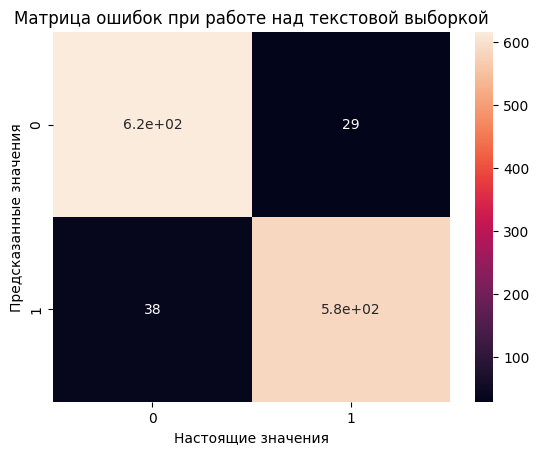

In [ ]:
sns.heatmap(cm, annot=True)
plt.title('Матрица ошибок при работе над текстовой выборкой')
plt.xlabel('Настоящие значения')
plt.ylabel('Предсказанные значения')

# Выводы


Ошибочных распознаваний вышло крайне мало:  
38 раз классификатор ошибся и принял фейковые новости за настоящие  
29 раз наоброт  
  
Надеюсь, заказчик будет доволен)